# 5. Algol

## 5.1. Notebook setup

In [1]:
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner

plt.style.use('../thermal-gs.mplstyle')
warnings.filterwarnings('ignore')

## 5.2. <a href="google.com">Download data</a>

Unzip into a folder named <font color='green'>data</font> in the same level as the notebooks folder

## 5.3. Load

In [2]:
freqs_model = np.loadtxt('../data/model_sed_freqs.txt').T
I_models = np.loadtxt('../data/Algol_I_models.txt')
V_models = np.loadtxt('../data/Algol_V_models.txt')
freqs_obs, I_obs, sI_obs, V_obs, sV_obs = np.loadtxt('../data/Algol_data.txt', unpack=True)

sampler = emcee.backends.HDFBackend('../../2021/fit_results/Algol/Algol_chain.h5')
samples = sampler.get_chain(flat=True)
samples /= np.array([1, 1, 1, 1, np.pi/180, np.pi/180])
lmfit_params = np.loadtxt('../data/Algol_lmfit_params.txt')
lmfit_params /= np.array([1, 1, 1, 1, np.pi/180, np.pi/180])

## 5.4. Plot

### 5.4.1. SED

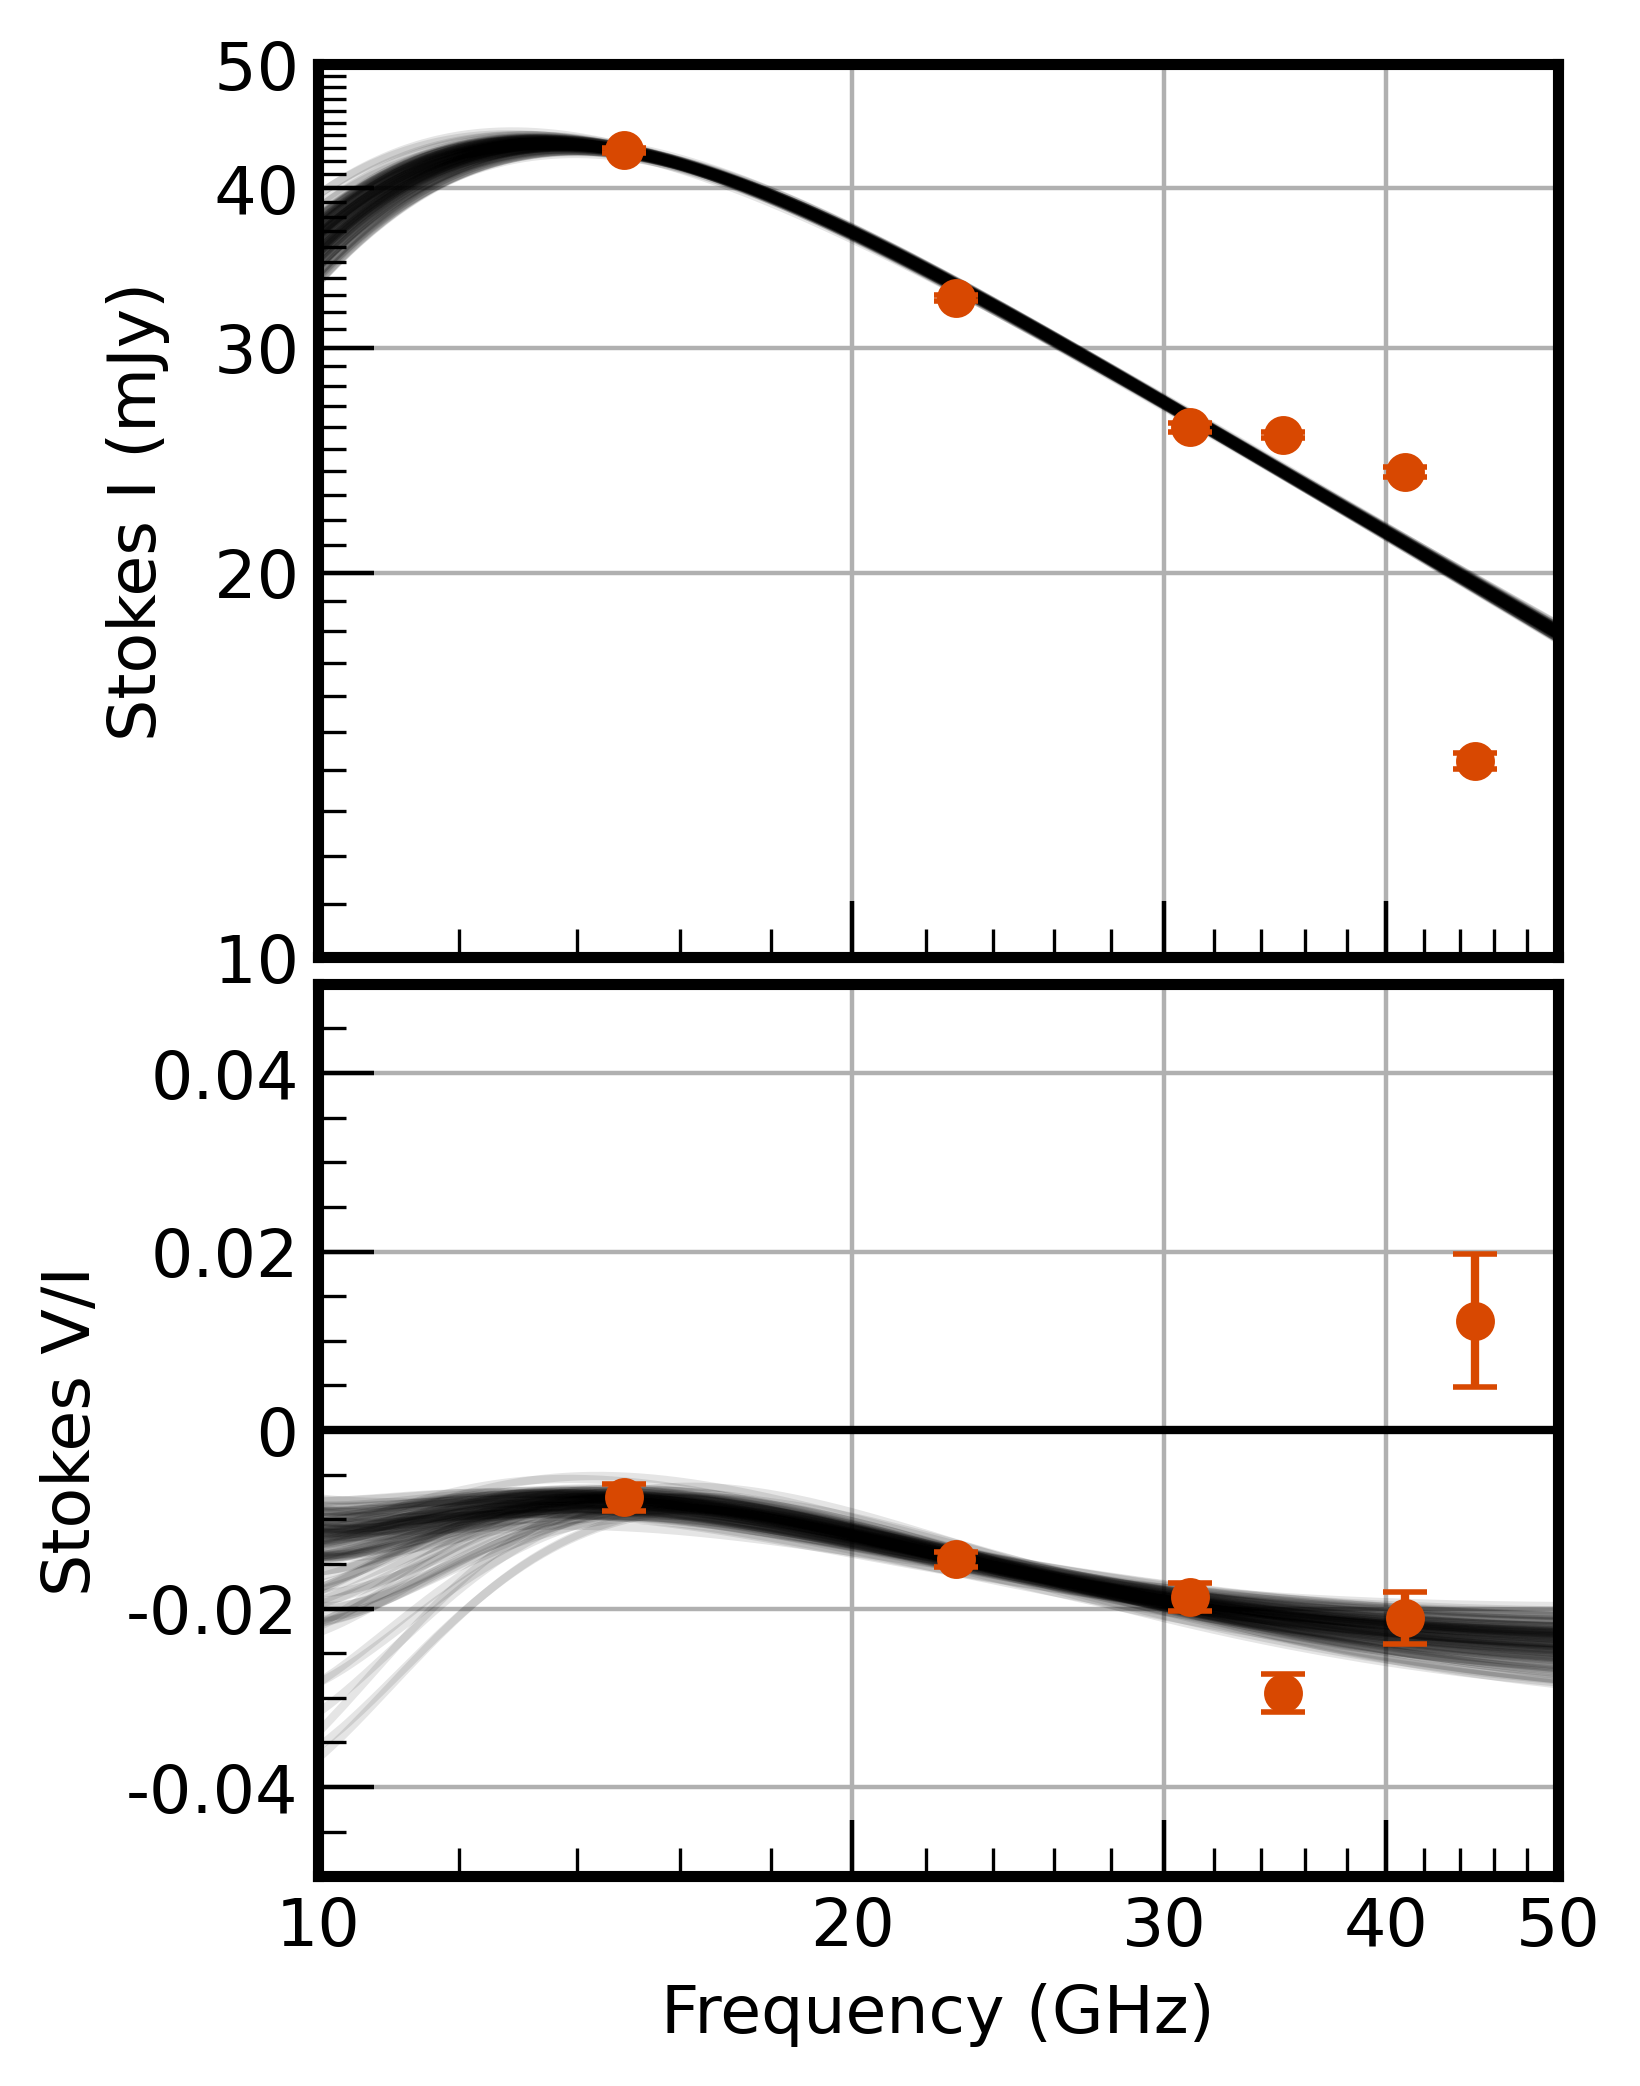

In [3]:
fig,ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
fig.subplots_adjust(hspace=0.03, wspace=0.3)
cmap = mpl.cm.get_cmap('Oranges')

# Stokes I  
ax[0].set_ylabel('Stokes I (mJy)')
ax[0].set_xlim(10, 50)
ax[0].set_ylim(10, 50)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%i'))
ax[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%3.3g'))
ax[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax[0].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=5, subs=[1, 2, 3, 4, 5]))
ax[0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, numticks=25, subs=np.arange(1, 25)*0.2))
ax[0].yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=5, subs=[1, 2, 3, 4, 5]))
ax[0].yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, numticks=40, subs=np.arange(10, 50)*0.1))
ax[0].grid()

for i in range(len(I_models)):
    ax[0].plot(freqs_model, I_models[i], color='black', alpha=0.1)
ax[0].errorbar(freqs_obs, I_obs, yerr=sI_obs, marker='o', color=cmap(0.75), linestyle='')

# Stokes V/I
ax[1].axhline(y=0, color='black')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Stokes V/I')
ax[1].set_ylim(-0.05, 0.05)

ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax[1].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%3.3g'))
ax[1].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax[1].xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=5, subs=[1, 2, 3, 4, 5]))
ax[1].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, numticks=25, subs=np.arange(1, 25)*0.2))
ax[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
ax[1].grid()

for i in range(len(V_models)):
    ax[1].plot(freqs_model, V_models[i]/I_models[i], color='black', alpha=0.1)
ax[1].errorbar(freqs_obs, V_obs/I_obs, yerr=np.sqrt((sI_obs/I_obs)**2+(sV_obs/V_obs)**2)*np.abs(V_obs/I_obs), 
    marker='o', color=cmap(0.75), linestyle='')

# Final setup
fig.set_facecolor('white')
plt.savefig('../figures/Algol_SED.png', bbox_inches='tight')
plt.savefig('../figures/Algol_SED.pdf', bbox_inches='tight')
plt.show()

### 5.4.2. Corner plot

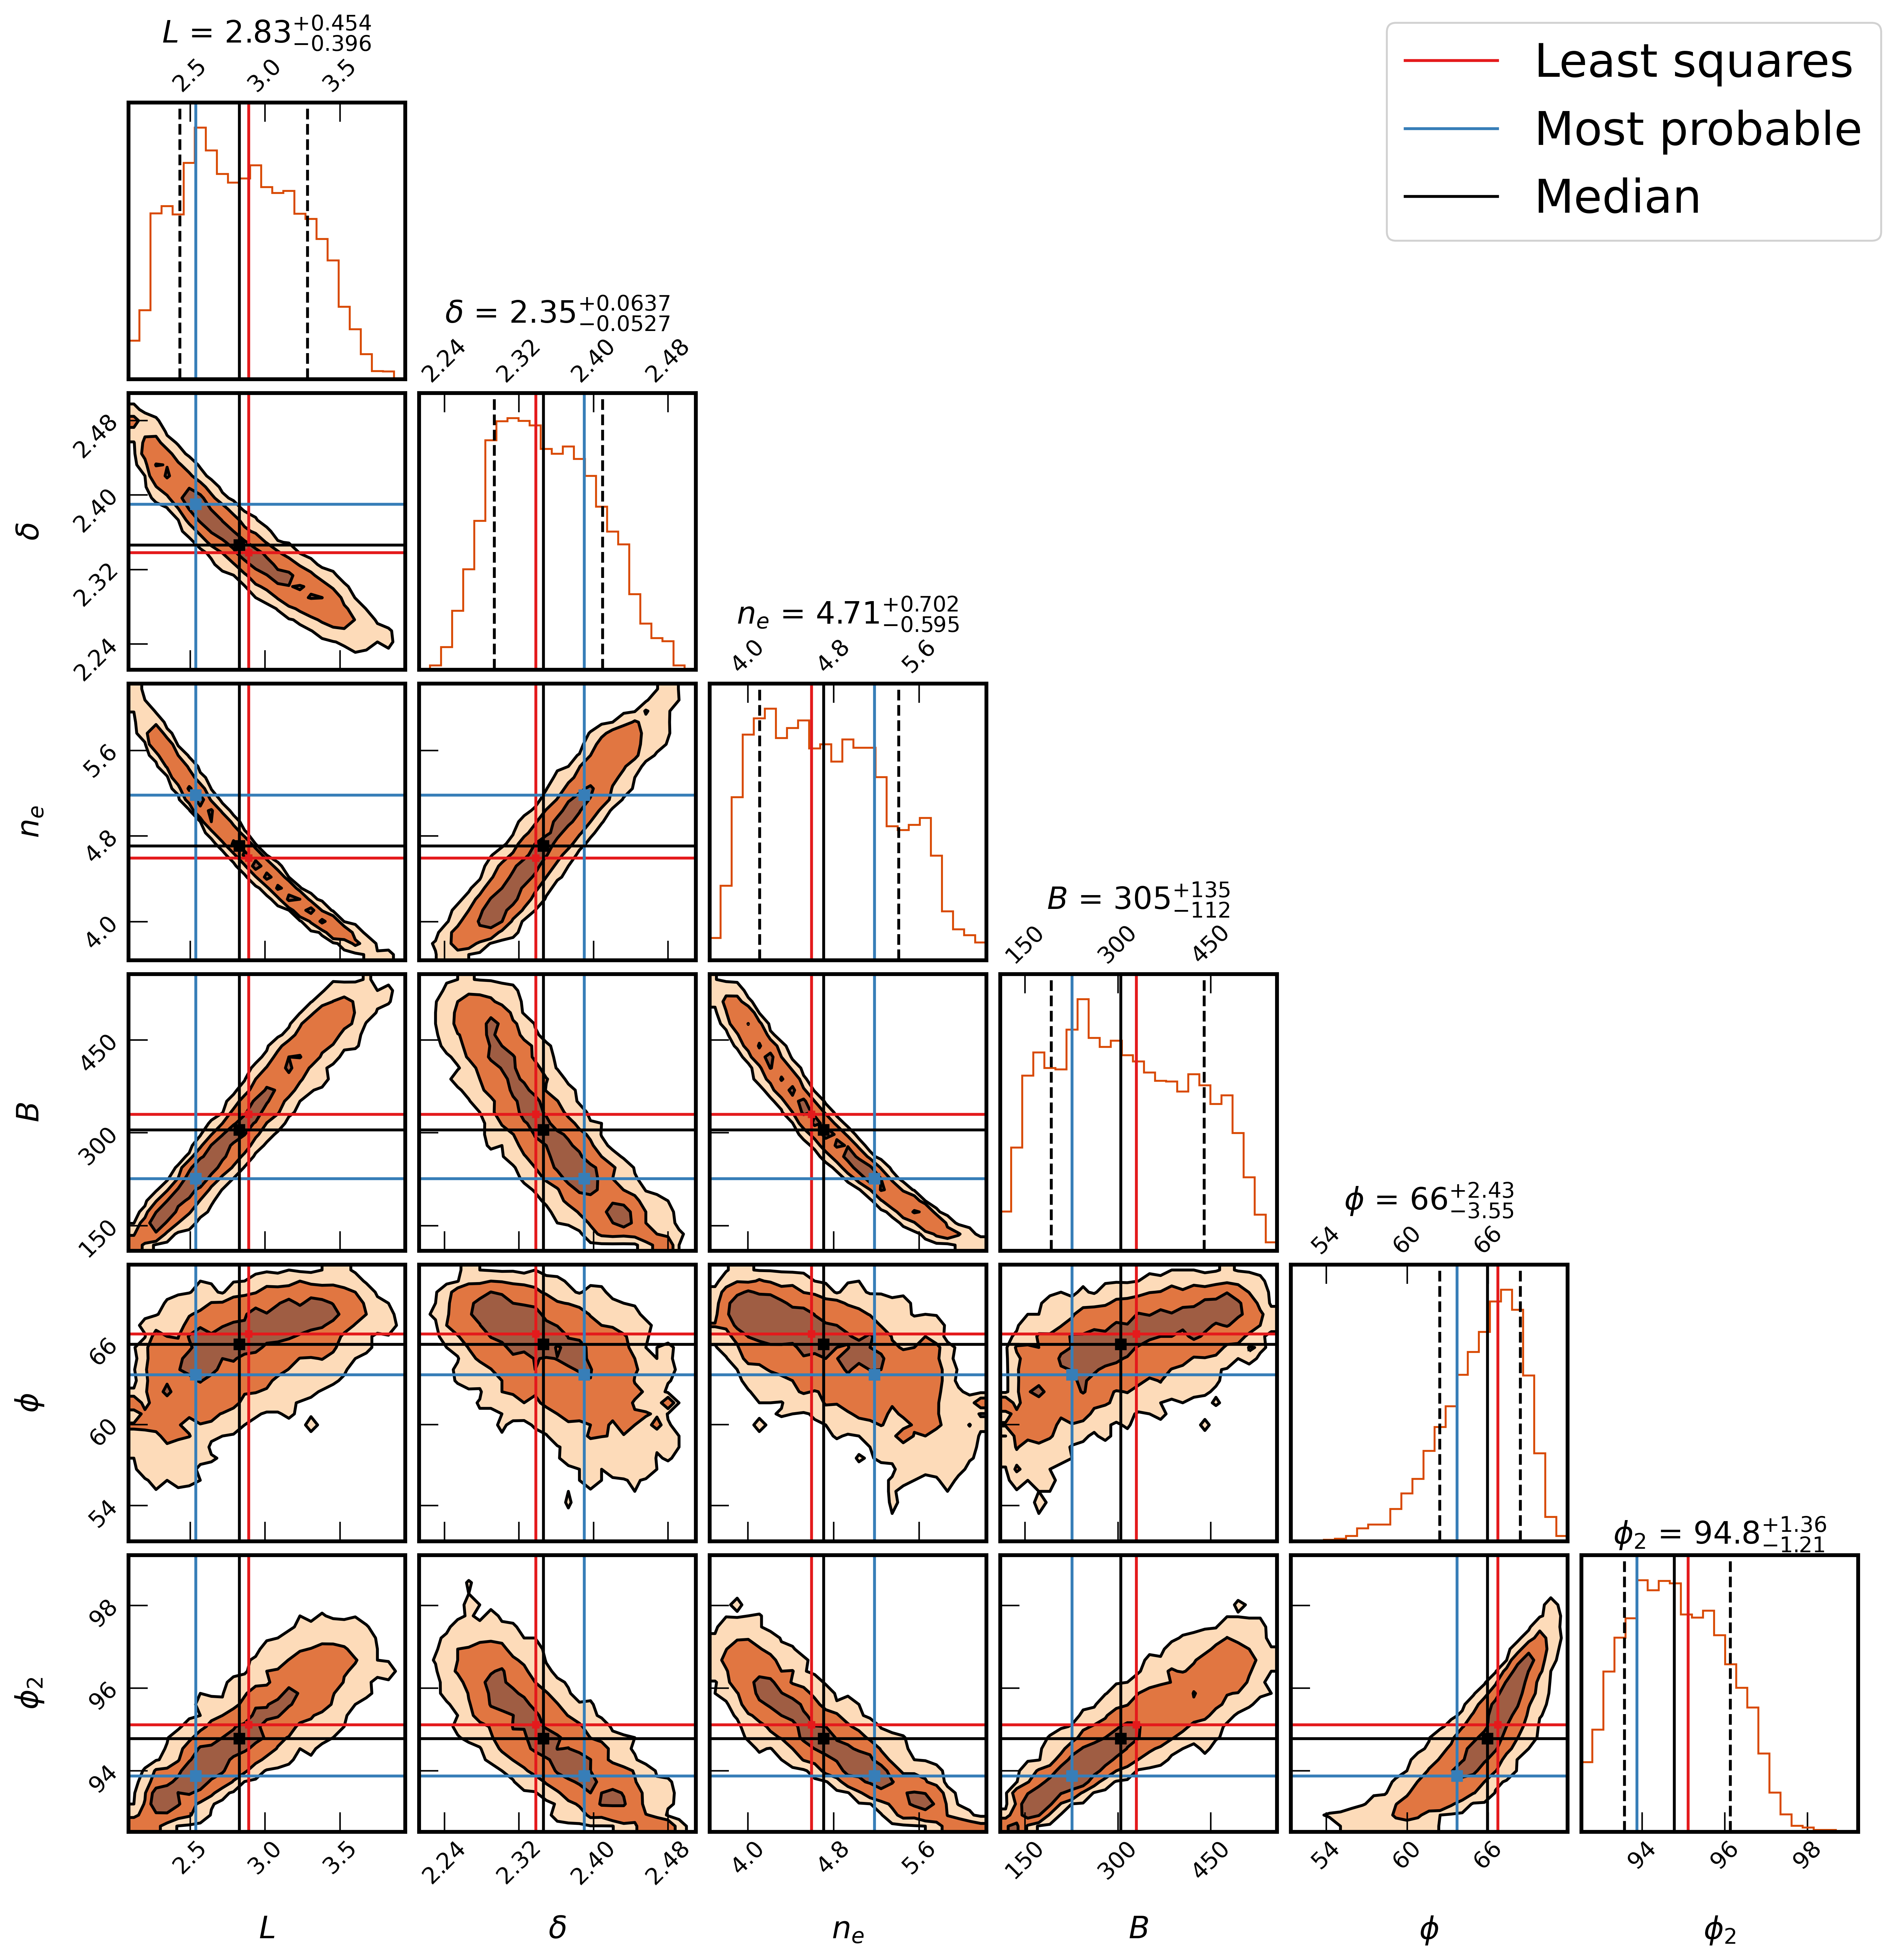

In [4]:
thin = 10000
plt_labels = ['$L$', '$\delta$', '$n_e$', '$B$', '$\phi$', '$\phi_2$']
median_values = np.median(samples[::thin, :], axis=0)
winnerWalker = np.argmax(sampler.get_log_prob(flat=True))
mostParams = samples[winnerWalker]
cmap.set_under(color='w')

cornerFig = corner.corner(samples[::thin, :],color='black',top_ticks=True,quiet=True, show_titles=True,use_math_text=True,
labels=plt_labels,plot_datapoints=False,quantiles=[0.16, 0.84], title_quantiles=[0.16, 0.5, 0.84], label_kwargs={"fontsize":16}, 
title_kwargs={"fontsize":16}, max_n_ticks=4, bins=25, title_fmt='3.3g', plot_density=False, fill_contours=True,
levels=(0.393, 0.865, 0.989), hist_kwargs={'color':cmap(0.75)}, 
contourf_kwargs={'colors':(cmap(-1), cmap(0.25), cmap(0.75), cmap(0.999)), 'alpha':0.75})

corner.overplot_lines(cornerFig, lmfit_params, color='C1', label='Least squares')
corner.overplot_points(cornerFig, np.array([lmfit_params]), color='C1', marker='s', ms=3)
corner.overplot_lines(cornerFig, mostParams, color='C0', label='Most probable')
corner.overplot_points(cornerFig, np.array([mostParams]), color='C0', marker='s', ms=5)
corner.overplot_lines(cornerFig, median_values, color='black', label='Median')
corner.overplot_points(cornerFig, np.array([median_values]), color='black', marker='s', ms=5)

handles,labels = cornerFig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
cornerFig.legend(by_label.values(), by_label.keys(), fontsize=24)
cornerFig.set_facecolor('white')
plt.savefig('../figures/Algol_corner.png', bbox_inches='tight')
plt.savefig('../figures/Algol_corner.pdf', bbox_inches='tight')
cornerFig.show()